# Imaging and deconvolution demonstration

This script makes a fake data set and then deconvolves it. Finally the full and residual visibility are plotted.

In [1]:
%matplotlib inline

import os
import sys
import multiprocessing

sys.path.append(os.path.join('..', '..'))

results_dir = './results'
os.makedirs(results_dir, exist_ok=True)

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (8.0, 8.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy


from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as const
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from arl.visibility.base import create_visibility
from arl.skycomponent.operations import create_skycomponent
from arl.image.operations import show_image, export_image_to_fits
from arl.image.deconvolution import deconvolve_cube, restore_cube
from arl.image.iterators import image_raster_iter
from arl.visibility.iterators import vis_timeslice_iter
from arl.util.testing_support import create_named_configuration, create_test_image
from arl.util.testing_support import create_low_test_image_from_s3
from arl.imaging import create_image_from_visibility, invert_2d, predict_2d

from arl.data.polarisation import PolarisationFrame

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

Construct LOW core configuration

In [2]:
lowcore = create_named_configuration('LOWBD2-CORE')

We create the visibility. This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [3]:
times = numpy.zeros([1])
frequency = numpy.array([1e8])
channel_bandwidth = numpy.array([1e6])
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-45.0 * u.deg, frame='icrs', equinox='J2000')
vt = create_visibility(lowcore, times, frequency, channel_bandwidth=channel_bandwidth,
                       weight=1.0, phasecentre=phasecentre, polarisation_frame=PolarisationFrame('stokesI'))

create_visibility: 13695 rows, 0.001 GB


Plot the synthesized uv coverage.

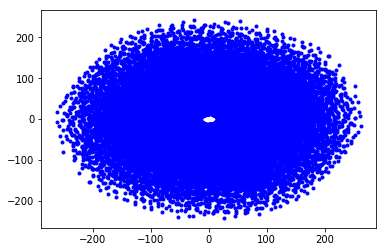

In [4]:
plt.clf()
plt.plot(vt.data['uvw'][:,0], vt.data['uvw'][:,1], '.', color='b')
plt.plot(-vt.data['uvw'][:,0], -vt.data['uvw'][:,1], '.', color='b')
plt.show()

Read the venerable test image, constructing an image

In [5]:
m31image = create_test_image(frequency=frequency, cellsize=0.0005)
# m31image = create_low_test_image_from_s3(frequency=frequency, cellsize=0.0005)
nchan, npol, ny, nx = m31image.data.shape
m31image.wcs.wcs.crval[0] = vt.phasecentre.ra.deg
m31image.wcs.wcs.crval[1] = vt.phasecentre.dec.deg
m31image.wcs.wcs.crpix[0] = float(nx // 2)
m31image.wcs.wcs.crpix[1] = float(ny // 2)

# fig=show_image(m31image)

import_image_from_fits: created >f4 image of shape (256, 256), size 0.000 (GB)
import_image_from_fits: Max, min in /mnt/nfs/chris/arl/data/models/M31.MOD = 1.006458, 0.000000
replicate_image: replicating shape (256, 256) to (1, 1, 256, 256)


predict_2d: predict using 2d transform
Using original algorithm
vis: complex128 (13695, 1)
kernels_c: complex128 (1, 8, 8, 8, 8)
kernel_indices_c: int32 (13695,)
uvgrid: complex128 (1, 1, 512, 512)
vuvwmap: float64 (13695, 3)
vfrequencymap_c: int32 (13695,)
convolutional_degrid time: 0.3875s
time: 0.49135470390319824


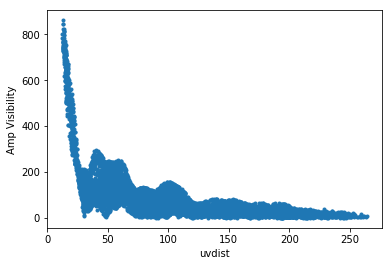

In [8]:
import time
start = time.time()
vt = predict_2d(vt, m31image)
stop = time.time()
elapsed = stop - start
print('time:', elapsed)

# To check that we got the prediction right, plot the amplitude of the visibility.
uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
plt.clf()
plt.plot(uvdist, numpy.abs(vt.data['vis']), '.')
plt.xlabel('uvdist')
plt.ylabel('Amp Visibility')
plt.show()

Make the dirty image and point spread function

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
invert_2d: inverting using 2d transform
Using optimized algorithm
time: 0.09202980995178223
invert_2d: inverting using 2d transform
Using optimized algorithm
time: 0.0864255428314209
Max, min in dirty image = 31.681079, -6.787823, sumwt = 0.052242
Max, min in PSF         = 0.999922, -0.007179, sumwt = 0.052242


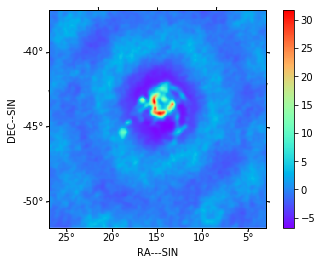

In [10]:
model = create_image_from_visibility(vt, cellsize=0.001, npixel=256)
start = time.time()
dirty, sumwt = invert_2d(vt, model)
stop = time.time()
elapsed = stop - start
print('time:', elapsed)

start = time.time()
psf, sumwt = invert_2d(vt, model, dopsf=True)
stop = time.time()
elapsed = stop - start
print('time:', elapsed)

show_image(dirty)
print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % (dirty.data.max(), dirty.data.min(), sumwt))

print("Max, min in PSF         = %.6f, %.6f, sumwt = %f" % (psf.data.max(), psf.data.min(), sumwt))

export_image_to_fits(dirty, '%s/imaging_dirty.fits'%(results_dir))
export_image_to_fits(psf, '%s/imaging_psf.fits'%(results_dir))

Deconvolve using clean

deconvolve_cube: Multi-scale clean of each polarisation and channel separately
deconvolve_cube: Processing pol 0, channel 0
msclean: Peak of PSF = 0.999921758198 at (128, 128)
msclean: Peak of Dirty = 31.6810787833 at (148, 123)
msclean: Coupling matrix =
 [[ 1.          0.96212636  0.57597563  0.11587394]
 [ 0.96212636  0.92658832  0.5617779   0.11527677]
 [ 0.57597563  0.5617779   0.39982619  0.10675899]
 [ 0.11587394  0.11527677  0.10675899  0.06262409]]
msclean: Max abs in dirty Image = 31.683558
msclean: Start of minor cycle
msclean: This minor cycle will stop at 1000 iterations or peak < 0.31683557762
msclean: Minor cycle 0, peak [ 24.18993582  24.10772264  23.07385262  16.23077719] at [136, 128, 3]
msclean: Minor cycle 100, peak [ 0.0191411   0.11454142  0.64334487  0.88088644] at [255, 197, 3]
msclean: Minor cycle 200, peak [ 1.08417363  1.08435826  1.08152791  0.89903147] at [22, 90, 3]
msclean: Minor cycle 300, peak [-0.95819935 -0.96180276 -1.00260502 -1.01284371] at [52, 25

Text(0.5,1,'Restored')

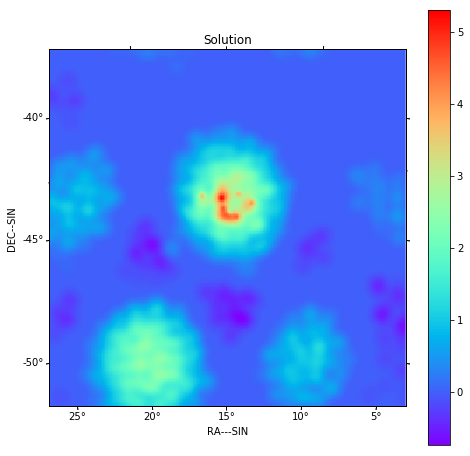

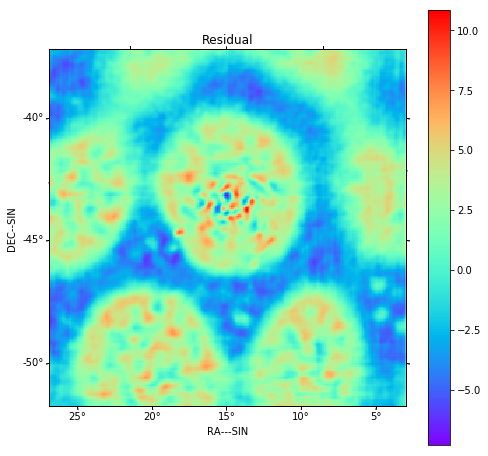

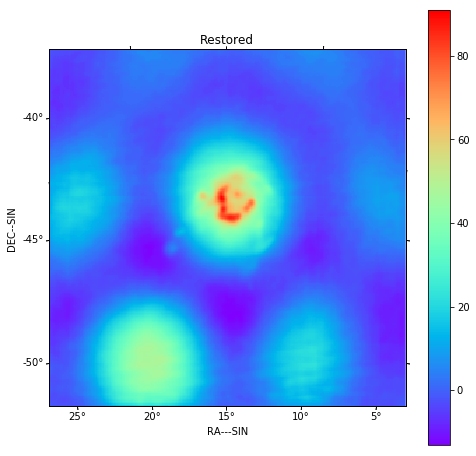

In [8]:
comp, residual = deconvolve_cube(dirty, psf, niter=1000, threshold=0.001, fracthresh=0.01, window_shape='quarter',
                                 gain=0.7, scales=[0, 3, 10, 30])

restored = restore_cube(comp, psf, residual)

# Show the results

fig=show_image(comp)
plt.title('Solution')
fig=show_image(residual)
plt.title('Residual')
fig=show_image(restored)
plt.title('Restored')

Predict the visibility of the model

In [9]:
vtmodel = create_visibility(lowcore, times, frequency, channel_bandwidth=channel_bandwidth,
                            weight=1.0, phasecentre=phasecentre, polarisation_frame=PolarisationFrame('stokesI'))
vtmodel=predict_2d(vtmodel, comp)

create_visibility: 13695 rows, 0.001 GB
predict_2d: predict using 2d transform
freq : 0.0265s
fft  : 0.0192s
grid : 0.0044s
shift: 0.1641s


Now we will plot the original visibility and the residual visibility.

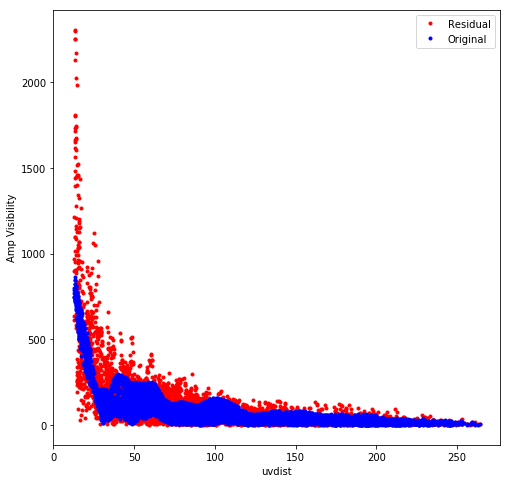

In [10]:
uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
plt.clf()
plt.plot(uvdist, numpy.abs(vt.data['vis'][:]-vtmodel.data['vis'][:]), '.', color='r', label='Residual')
plt.plot(uvdist, numpy.abs(vt.data['vis'][:]), '.', color='b', label='Original')

plt.xlabel('uvdist')
plt.ylabel('Amp Visibility')
plt.legend()
plt.show()